# Importing Necessary Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import r_regression, f_regression

# Biphasic Filter for Differentiation

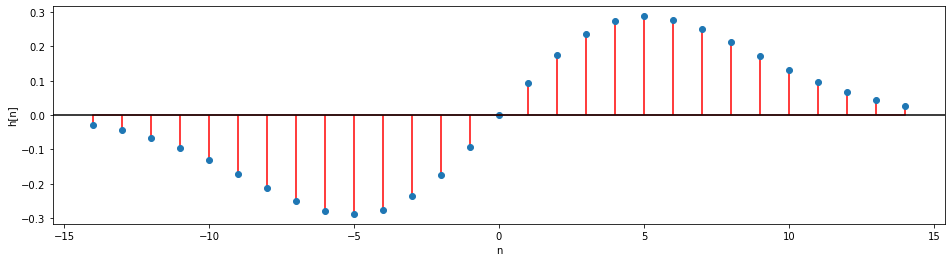

In [2]:
def get_biphasic(w, tu1, tu2, d1, d2):
    """
    Generates a biphasic filter based on Gaussian distributions.

    Parameters:
    w   : int - The half-width of the filter window (number of points).
    tu1 : float - Standard deviation for the first Gaussian (rise phase).
    tu2 : float - Standard deviation for the second Gaussian (fall phase).
    d1  : float - Mean (center) of the first Gaussian.
    d2  : float - Mean (center) of the second Gaussian.

    Returns:
    n       : numpy array - The sample points centered around 0.
    bi_ph   : numpy array - The biphasic filter response.
    """
    
    # Generate a symmetric range of n values from -(w-1) to w-1
    n = np.arange(-(w-1), w)
    
    # Calculate the first Gaussian function (rising phase)
    A = 1 / (tu1 * np.sqrt(2 * np.pi)) * np.exp(-((n - d1) ** 2) / (2 * tu1 ** 2))
    
    # Calculate the second Gaussian function (falling phase)
    B = 1 / (tu2 * np.sqrt(2 * np.pi)) * np.exp(-((n - d2) ** 2) / (2 * tu2 ** 2))
    
    # The biphasic filter is the difference between the two Gaussians
    bi_ph = A - B
    
    # Return both the sample points and the biphasic filter response
    return n, bi_ph

# Set the figure size for the plot
plt.rcParams["figure.figsize"] = (16, 4)

# Define the range for n values for plotting
n1 = np.arange(-51, 52)

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Generate the biphasic filter with specific parameters
n1, bi_ph = get_biphasic(15, 5, 5, 1, -1)

# Normalize the biphasic filter response
bi_ph_normed = bi_ph / np.linalg.norm(bi_ph)

# Plot the normalized biphasic filter using a stem plot
ax.stem(n1, bi_ph_normed, linefmt='ro')

# Set the labels for the x and y axes
ax.set_xlabel('n')
ax.set_ylabel('h[n]')

# Add a horizontal line at y=0 for reference
ax.axhline(0, color='k')

# Show the plot
plt.show()

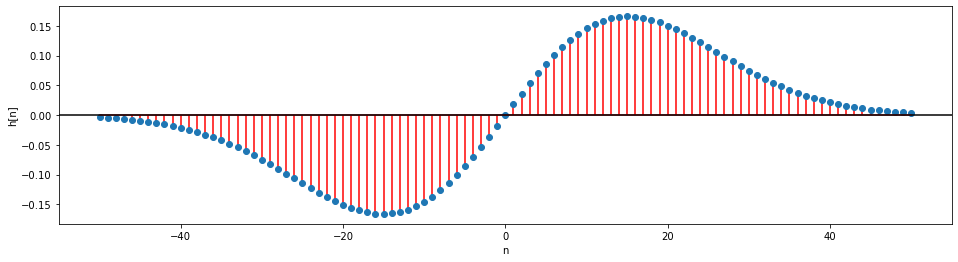

In [4]:
# Getting a similar filter with different parameters for kinematic contours

n1=np.arange(-51,52)
fig,ax = plt.subplots()
n1_gesture,bi_ph_gesture = get_biphasic(51,15,15,2,-2)
bi_ph_normed_gesture = bi_ph_gesture/np.linalg.norm(bi_ph_gesture)
ax.stem(n1_gesture,bi_ph_normed_gesture,linefmt='ro')
ax.set_xlabel('n')
ax.set_ylabel('h[n]')
ax.axhline(0,color='k');

In [5]:
def convolved_diff(x):
    '''
    Function for convolving a signal with biphasic filter
    '''
    return -np.convolve(x,bi_ph_normed,'same')

def convolved_diff_gesture(x):
    '''
    Function for convolving a signal with gesture biphasic filter
    '''
    return -np.convolve(x,bi_ph_normed_gesture,'same')

In [26]:
df = pd.DataFrame([])

for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:

    # Iterate over all singers and read their masterfiles
    #Change location (filepath) as necessary
    singer_df = pd.read_csv(f'./../Data/check_output_Jan20/check_output_v2/{singer}_gesture_pitch_pd_with_vel_accln.csv',
                            usecols=['filename','time','pitch','LWrist_vel_y','RWrist_vel_y',
                                    'LWrist_vel_3d','RWrist_vel_3d'])
    # Concatenating this singer's data to a combined df
    df = pd.concat([df,singer_df])
    print(singer)

AG
AK
AP
CC
MG
MP
NM
RV
SCh
SM
SS


In [27]:
df.reset_index(drop=True, inplace=True)
#Replace pathological values by np.nan
df['pitch'] = df['pitch'].apply(lambda x: x if x>-1000 else np.nan)

# Correlation between Peaks in Gestures and $|\Delta F0|$

In [11]:
filelist = df['filename'].unique()
filelist = [x for x in filelist if 'MP' in x] #Choose singer here
filelist # List of files to be processed in this run

['MP_Aalap1_Bag.csv',
 'MP_Aalap1_Bahar.csv',
 'MP_Aalap1_Bilas.csv',
 'MP_Aalap1_Jaun.csv',
 'MP_Aalap1_Kedar.csv',
 'MP_Aalap1_MM.csv',
 'MP_Aalap1_Marwa.csv',
 'MP_Aalap1_Nand.csv',
 'MP_Aalap1_Shree.csv',
 'MP_Aalap2_Bag.csv',
 'MP_Aalap2_Bahar.csv',
 'MP_Aalap2_Bilas.csv',
 'MP_Aalap2_Jaun.csv',
 'MP_Aalap2_Kedar.csv',
 'MP_Aalap2_MM.csv',
 'MP_Aalap2_Marwa.csv',
 'MP_Aalap2_Nand.csv',
 'MP_Aalap2_Shree.csv',
 'MP_Pakad_Bag.csv',
 'MP_Pakad_Bahar.csv',
 'MP_Pakad_Bilas.csv',
 'MP_Pakad_Jaun.csv',
 'MP_Pakad_Kedar.csv',
 'MP_Pakad_MM.csv',
 'MP_Pakad_Marwa.csv',
 'MP_Pakad_Nand.csv',
 'MP_Pakad_Shree.csv']

In [28]:
def correlate_peaks_v2(segment, target_col_list,left_con = 50,right_con = 50):
    
    pitch = segment['pitch'] # pitch contour
    delta_F0 = convolved_diff(pitch.values) # derivative of pitch contour
    segment['Delta_F0'] = np.abs(delta_F0) # absolute magnitude of derivative of pitch contour
    
    return_dict = {}
    
    for target_col in target_col_list:
        
        # Setting threshold to define peaks in kinematic contour as mean over the entire segment
        pos_threshold = segment[target_col].mean()  
        neg_threshold = segment[target_col].mean()
        
        # Finding positive peaks (refer to scipy.signal.find_peaks for docs)
        pos_peaks = signal.find_peaks(segment[target_col], 
                                  height = pos_threshold, 
                                  distance = max(left_con,right_con))
        # Finding negative peaks (refer to scipy.signal.find_peaks for docs)
        neg_peaks = signal.find_peaks(-segment[target_col], 
                                  height = -neg_threshold, 
                                  distance = max(left_con,right_con))
        
        pos_reg_data = [] # Regression data for positive peaks
        neg_reg_data = [] # Regression data for negative peaks

        for i, peak_loc in enumerate(pos_peaks[0]):
            height = pos_peaks[1]['peak_heights'][i]
            # Defining window in delta F0 corresponding to kinematic peak location
            peak_window = segment.loc[peak_loc-left_con:peak_loc+right_con, 'Delta_F0']
            if np.isnan(np.array(peak_window)).sum() > 75:
                continue # if more than 75% of the window is nan, don't include it
            peaks_F0 = signal.find_peaks(peak_window, 
                                         height = 100, distance = 50)
            if len(peaks_F0[0]) == 0:
                pos_reg_data.append([height, 0, peak_loc, -3000]) #-3000 is a placeholder
            else:
                idx_max_peak = np.argmax(peaks_F0[1]['peak_heights']) # argmax to find peak in delta F0 window
                pos_reg_data.append([height, peaks_F0[1]['peak_heights'][idx_max_peak], 
                                     peak_loc, peaks_F0[0][idx_max_peak]])

        pos_reg_data = pd.DataFrame(pos_reg_data, columns = [target_col,'Delta_F0',
                                                             target_col+'_loc','Delta_F0_loc'])
        pos_reg_data = pos_reg_data.dropna(axis = 0)
        
        for i, peak_loc in enumerate(neg_peaks[0]):
            height = neg_peaks[1]['peak_heights'][i]
            # Defining window in delta F0 corresponding to kinematic peak location
            peak_window = segment.loc[peak_loc-left_con:peak_loc+right_con, 'Delta_F0']
            if np.isnan(np.array(peak_window)).sum() > 75:
                continue # if more than 75% of the window is nan, don't include it
            peaks_F0 = signal.find_peaks(peak_window, 
                                         height = 100, distance = 50)
            if len(peaks_F0[0]) == 0:
                maximum = 0
                dF0_peak_loc = -3000
            else:
                idx_max_peak = np.argmax(peaks_F0[1]['peak_heights']) # argmax to find peak in delta F0 window
                maximum = peaks_F0[1]['peak_heights'][idx_max_peak] # vertical height of delta F0 peak
                dF0_peak_loc = peaks_F0[0][idx_max_peak] # time location of delta F0 peak
                
            if target_col in ['RWrist_vel_3d','LWrist_vel_3d']: # These two column names correspond to "speed" in our masterfiles
                neg_reg_data.append([-height, maximum,peak_loc, dF0_peak_loc])
            else:
                neg_reg_data.append([height, maximum,peak_loc, dF0_peak_loc])        
                
        
        neg_reg_data = pd.DataFrame(neg_reg_data, columns = [target_col,'Delta_F0',
                                                             target_col+'_loc','Delta_F0_loc'])
        neg_reg_data = neg_reg_data.dropna(axis = 0)        
        
        return_dict[target_col] = (pos_reg_data, neg_reg_data)
        
    return return_dict

In [37]:
def correlate_peaks(segment, target_col_list,left_con = 50,right_con = 50):
    
    pitch = segment['pitch']
    delta_F0 = convolved_diff(pitch.values)
    segment['Delta_F0'] = np.abs(delta_F0)
    
    return_dict = {}
    
    for target_col in target_col_list:
#         print(target_col)
        pos_threshold = segment[target_col].mean() # + segment[target_col].std()
        neg_threshold = (segment[target_col]).mean() #+ (-segment[target_col]).std()
        
        pos_peaks = signal.find_peaks(segment[target_col], 
                                  height = pos_threshold, 
                                  distance = max(left_con,right_con))
        neg_peaks = signal.find_peaks(-segment[target_col], 
                                  height = -neg_threshold, 
                                  distance = max(left_con,right_con))

        pos_reg_data = []
        neg_reg_data = []

        for i, peak_loc in enumerate(pos_peaks[0]):
            height = pos_peaks[1]['peak_heights'][i]
            peak_window = segment.loc[peak_loc-left_con:peak_loc+right_con, 'Delta_F0']
            maximum = np.nanmax(peak_window)
            dF0_peak_loc = np.argmax(peak_window)
            pos_reg_data.append([height, maximum, peak_loc, dF0_peak_loc])

        pos_reg_data = pd.DataFrame(pos_reg_data, columns = [target_col,'Delta_F0',
                                                             target_col+'_loc','Delta_F0_loc'])
        pos_reg_data = pos_reg_data.dropna(axis = 0)
        
        for i, peak_loc in enumerate(neg_peaks[0]):
            height = neg_peaks[1]['peak_heights'][i]
            peak_window = segment.loc[peak_loc-left_con:peak_loc+right_con, 'Delta_F0']
            maximum = np.nanmax(peak_window)
            dF0_peak_loc = np.argmax(peak_window)
            if target_col in ['RWrist_vel_3d','LWrist_vel_3d']:
                neg_reg_data.append([-height, maximum,peak_loc, dF0_peak_loc])
            else:
                neg_reg_data.append([height, maximum,peak_loc, dF0_peak_loc])
                
        neg_reg_data = pd.DataFrame(neg_reg_data, columns = [target_col,'Delta_F0',
                                                             target_col+'_loc','Delta_F0_loc'])
        neg_reg_data = neg_reg_data.dropna(axis = 0)        
        
        return_dict[target_col] = (pos_reg_data, neg_reg_data)
        
    return return_dict

In [38]:
a = np.array([np.nan]*10)
np.isnan(a).sum()

10

In [29]:
all_dicts = {}

for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:

    print(singer)
    filelist = df['filename'].unique() 
    filelist = [x for x in filelist if singer in x] # files corresponding to this singer

    # kinematic contours to be processed (vertical velocity, speed, acceleration)
    target_col_list=['RWrist_vel_y','LWrist_vel_y', 
                     'RWrist_vel_3d', 'LWrist_vel_3d',
                     'RWrist_vel_accl','LWrist_vel_accl']
    
    for filename in filelist:
        segment = df.loc[df['filename']==filename].reset_index(drop=True)
        # Defining acceleration here as derivative of the speed
        segment['RWrist_vel_accl'] = convolved_diff(segment['RWrist_vel_3d'].values)
        segment['LWrist_vel_accl'] = convolved_diff(segment['LWrist_vel_3d'].values)
        peak_dict = correlate_peaks_v2(segment, target_col_list)
        all_dicts[filename] = peak_dict

AG
AK
AP
CC
MG
MP
NM
RV
SCh
SM
SS


In [41]:
# plt.plot(segment['RWrist_vel_3d'])
# plt.plot(segment['RWrist_vel_accl'])
# plt.legend(['Speed','Accl'])

# Carrying out Regression

In [30]:
results =[]
pvalues = []

for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
# for singer in ['AG']:
    print(singer)
    results_this_singer = [singer]
    pvalues_this_singer = [singer]
    
    filelist = df['filename'].unique()
    filelist = [x for x in filelist if singer in x]
    
    for target_col in target_col_list:
        pos_reg_data_singer = pd.DataFrame([])
        neg_reg_data_singer = pd.DataFrame([])
        
        for filename in filelist:
            pos_reg_data = all_dicts[filename][target_col][0]
            pos_reg_data_singer = pd.concat([pos_reg_data_singer, pos_reg_data])
            neg_reg_data = all_dicts[filename][target_col][1]
            neg_reg_data_singer = pd.concat([neg_reg_data_singer, neg_reg_data])
        
        pos_reg_data_singer.drop(index= pos_reg_data_singer.index[pos_reg_data_singer[target_col]<0.001], inplace=True)
        neg_reg_data_singer.drop(index= neg_reg_data_singer.index[neg_reg_data_singer[target_col]<0.001], inplace=True)   
        
        pos_corr_coef = r_regression(X = np.log((np.array(pos_reg_data_singer[target_col]).reshape(-1,1))),
                                 y = (pos_reg_data_singer['Delta_F0']))[0]
        neg_corr_coef = r_regression(X = np.log((np.array(neg_reg_data_singer[target_col]).reshape(-1,1))),
                                 y = (neg_reg_data_singer['Delta_F0']))[0]
        all_corr_coef = r_regression(X = np.log(np.concatenate([np.array(pos_reg_data_singer[target_col]),
                                                         np.array(neg_reg_data_singer[target_col])]).reshape(-1,1)),
                                    y =(np.concatenate([np.array(pos_reg_data_singer['Delta_F0']), 
                                                     np.array(neg_reg_data_singer['Delta_F0'])])))[0]
        
        pos_pval = f_regression(X = np.log((np.array(pos_reg_data_singer[target_col]).reshape(-1,1))),
                                 y = (pos_reg_data_singer['Delta_F0']))[1]
        neg_pval = f_regression(X = np.log((np.array(neg_reg_data_singer[target_col]).reshape(-1,1))),
                                 y = (neg_reg_data_singer['Delta_F0']))[1]
        all_pval = f_regression(X = np.log(np.concatenate([np.array(pos_reg_data_singer[target_col]),
                                                         np.array(neg_reg_data_singer[target_col])]).reshape(-1,1)),
                                    y =(np.concatenate([np.array(pos_reg_data_singer['Delta_F0']), 
                                                     np.array(neg_reg_data_singer['Delta_F0'])])))[1]
        
        results_this_singer.append(pos_corr_coef)
        results_this_singer.append(neg_corr_coef)
        results_this_singer.append(all_corr_coef)
        
        pvalues_this_singer.append(pos_pval[0])
        pvalues_this_singer.append(neg_pval[0])
        pvalues_this_singer.append(all_pval[0])
    
    results.append(results_this_singer)
    pvalues.append(pvalues_this_singer)

AG
AK
AP
CC
MG
MP
NM
RV
SCh
SM
SS


In [31]:
all_columns = [[x+'+']+[x+'-']+[x] for x in target_col_list]

def flatten(xss):
    return [x for xs in xss for x in xs]

flatten(all_columns)

['RWrist_vel_y+',
 'RWrist_vel_y-',
 'RWrist_vel_y',
 'LWrist_vel_y+',
 'LWrist_vel_y-',
 'LWrist_vel_y',
 'RWrist_vel_3d+',
 'RWrist_vel_3d-',
 'RWrist_vel_3d',
 'LWrist_vel_3d+',
 'LWrist_vel_3d-',
 'LWrist_vel_3d',
 'RWrist_vel_accl+',
 'RWrist_vel_accl-',
 'RWrist_vel_accl',
 'LWrist_vel_accl+',
 'LWrist_vel_accl-',
 'LWrist_vel_accl']

In [32]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# Displaying regression results

In [36]:
results = pd.DataFrame(results, columns = ['Singer']+flatten(all_columns))
results = results.round(2)
pvalues = pd.DataFrame(pvalues, columns = ['Singer']+flatten(all_columns))
pvalues = pvalues.round(4)

In [37]:
results[[x for x in results.columns.values if '-' not in x and '+' not in x]]

,Singer,RWrist_vel_y,LWrist_vel_y,RWrist_vel_3d,LWrist_vel_3d,RWrist_vel_accl,LWrist_vel_accl
0,AG,0.32,0.20,0.27,0.17,0.40,0.22
1,AK,0.17,0.12,0.11,0.10,0.19,0.12
2,AP,0.06,0.15,0.02,0.12,0.09,0.12
3,CC,0.29,0.37,0.27,0.36,0.40,0.39
4,MG,0.02,0.05,-0.01,0.02,0.10,0.07
5,MP,0.08,0.15,0.05,0.16,0.09,0.19
6,NM,-0.01,0.14,0.03,0.08,0.19,0.09
7,RV,0.14,0.14,0.13,0.12,0.16,0.16
8,SCh,0.25,0.20,0.20,0.16,0.29,0.14
9,SM,0.08,0.16,0.03,0.09,0.12,0.18


In [38]:
pvalues[[x for x in pvalues.columns.values if '-' not in x and '+' not in x]]

,Singer,RWrist_vel_y,LWrist_vel_y,RWrist_vel_3d,LWrist_vel_3d,RWrist_vel_accl,LWrist_vel_accl
0,AG,0.0000,0.0000,0.0000,0.0000,0.0,0.0
1,AK,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2,AP,0.0000,0.0000,0.1001,0.0000,0.0,0.0
3,CC,0.0000,0.0000,0.0000,0.0000,0.0,0.0
4,MG,0.2380,0.0001,0.7138,0.0755,0.0,0.0
5,MP,0.0000,0.0000,0.0003,0.0000,0.0,0.0
6,NM,0.5331,0.0000,0.0636,0.0000,0.0,0.0
7,RV,0.0000,0.0000,0.0000,0.0000,0.0,0.0
8,SCh,0.0000,0.0000,0.0000,0.0000,0.0,0.0
9,SM,0.0000,0.0000,0.0534,0.0000,0.0,0.0


# Displaying regression plots

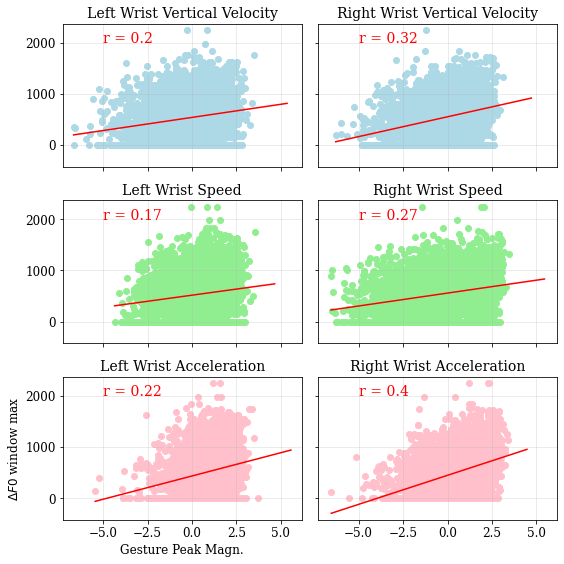

In [53]:
# Displaying plots for singer AG

from sklearn.linear_model import LinearRegression

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

text_locs = [(-5,2000),(-5,2000), (-5,2000),(-5,2000),(-5,2000),(-5,2000)]

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize = (8,8),sharey=True, sharex=True)

axes = [ax1,ax2,ax3,ax4,ax5,ax6]


# ax1.text()
titles = ['Left Wrist Vertical Velocity', 'Right Wrist Vertical Velocity',
          'Left Wrist Speed','Right Wrist Speed',
          'Left Wrist Acceleration','Right Wrist Acceleration']
scatter_colors = ['lightblue','lightblue','lightgreen','lightgreen','pink','pink']

target_col_list_reordered = ['LWrist_vel_y','RWrist_vel_y',
                             'LWrist_vel_3d','RWrist_vel_3d',
                             'LWrist_vel_accl','RWrist_vel_accl']

for i,target_col in enumerate(target_col_list_reordered):
    
    all_file_reg_data = pd.DataFrame([])
    
    for filename in all_dicts.keys():
        if 'AG' not in filename:
            continue
        this_file_reg_data = pd.concat(list(all_dicts[filename][target_col]))
        all_file_reg_data = pd.concat([all_file_reg_data, 
                                       this_file_reg_data])
    lr = LinearRegression()
    
    all_file_reg_data.drop(index=all_file_reg_data.index[all_file_reg_data[target_col]<0.001], inplace=True)
    
    X = np.log(np.array(all_file_reg_data[target_col]).reshape(-1,1))
    y = all_file_reg_data['Delta_F0']
    lr.fit(X = X,
           y = y)
    
    m = lr.coef_[0]
    c = lr.intercept_
    x = np.arange(min(X),max(X)+2,1)
    
    axes[i].scatter(X,y,color = scatter_colors[i])
    axes[i].plot(x,m*x+c, color = 'red')
    axes[i].text(x = text_locs[i][0], y=text_locs[i][1], 
                 s = 'r = ' + str(results.loc[0,target_col]), 
                 color = 'red', fontsize = 14)
    axes[i].set_title(titles[i], fontsize = 14)
    axes[i].grid(alpha=  0.3)
    
axes[4].set_xlabel('Gesture Peak Magn.', fontsize = 12)
axes[4].set_ylabel('$\Delta F0$ window max', fontsize = 12)
plt.tight_layout()
plt.savefig('./AG_magnitude_coupling_log.png',facecolor='white')
plt.show();

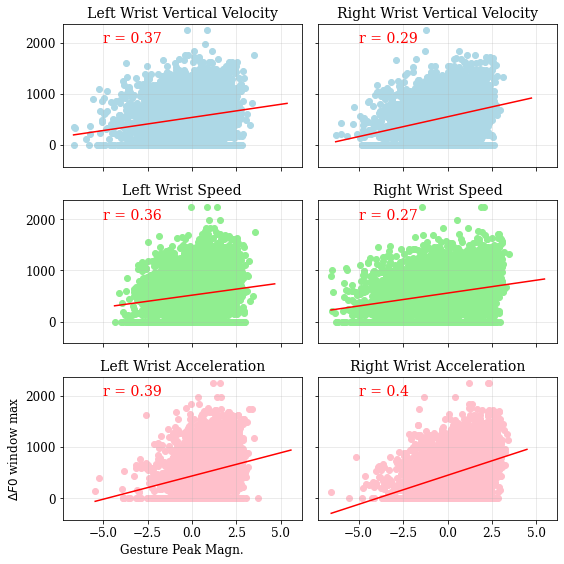

In [54]:
from sklearn.linear_model import LinearRegression

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

text_locs = [(-5,2000),(-5,2000), (-5,2000),(-5,2000),(-5,2000),(-5,2000)]

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize = (8,8),sharey=True, sharex = True)

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

titles = ['Left Wrist Vertical Velocity', 'Right Wrist Vertical Velocity',
          'Left Wrist Speed','Right Wrist Speed',
          'Left Wrist Acceleration','Right Wrist Acceleration']
scatter_colors = ['lightblue','lightblue','lightgreen','lightgreen','pink','pink']

target_col_list_reordered = ['LWrist_vel_y','RWrist_vel_y',
                             'LWrist_vel_3d','RWrist_vel_3d',
                             'LWrist_vel_accl','RWrist_vel_accl']

for i,target_col in enumerate(target_col_list_reordered):
    
    all_file_reg_data = pd.DataFrame([])
    
    for filename in all_dicts.keys():
        if 'AG' not in filename:
            continue
        this_file_reg_data = pd.concat(list(all_dicts[filename][target_col]))
        all_file_reg_data = pd.concat([all_file_reg_data, 
                                       this_file_reg_data])
    lr = LinearRegression()
    
    all_file_reg_data.drop(index=all_file_reg_data.index[all_file_reg_data[target_col]<0.001], inplace=True)
    
    X = np.log(np.array(all_file_reg_data[target_col]).reshape(-1,1))
    y = all_file_reg_data['Delta_F0']
    lr.fit(X = X,
           y = y)
    
    m = lr.coef_[0]
    c = lr.intercept_
    x = np.arange(min(X),max(X)+2,1)
#     print(target_col, 'Slope:', m, 'Intercept:', c)
    
    
    axes[i].scatter(X,y,color = scatter_colors[i])
    axes[i].plot(x,m*x+c, color = 'red')
    axes[i].text(x = text_locs[i][0], y = text_locs[i][1], 
                 s = 'r = ' + str(results.loc[3,target_col]), 
                 color = 'red', fontsize = 14)
    axes[i].set_title(titles[i], fontsize = 14)
    axes[i].grid(alpha=  0.3)
    
axes[4].set_xlabel('Gesture Peak Magn.', fontsize = 12)
axes[4].set_ylabel('$\Delta F0$ window max', fontsize = 12)
plt.tight_layout()
plt.savefig('./CC_magnitude_coupling_log.png',facecolor='white')
plt.show();

# Time Location Data

In [55]:
pos_loc_data_all = {}
neg_loc_data_all = {}

# for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
for singer in ['AG','CC']:
    print(singer)
    
    filelist = df['filename'].unique()
    filelist = [x for x in filelist if singer in x]
    
    pos_loc_data_this_singer = {}
    neg_loc_data_this_singer = {}
    
    for target_col in target_col_list:
        pos_loc_data_this_col = pd.DataFrame([])
        neg_loc_data_this_col = pd.DataFrame([])
        
        for filename in filelist:
            pos_loc_data_this_file = all_dicts[filename][target_col][0][[target_col+'_loc','Delta_F0_loc']]
            pos_loc_data_this_col = pd.concat([pos_loc_data_this_col, pos_loc_data_this_file])
            neg_loc_data_this_file = all_dicts[filename][target_col][1][[target_col+'_loc','Delta_F0_loc']]
            neg_loc_data_this_col = pd.concat([neg_loc_data_this_col, neg_loc_data_this_file])
            
        pos_loc_data_this_singer[target_col] = pos_loc_data_this_col
        neg_loc_data_this_singer[target_col] = neg_loc_data_this_col
    
    pos_loc_data_all[singer] = pos_loc_data_this_singer
    neg_loc_data_all[singer] = neg_loc_data_this_singer

AG
CC


In [56]:
from scipy.stats import gaussian_kde

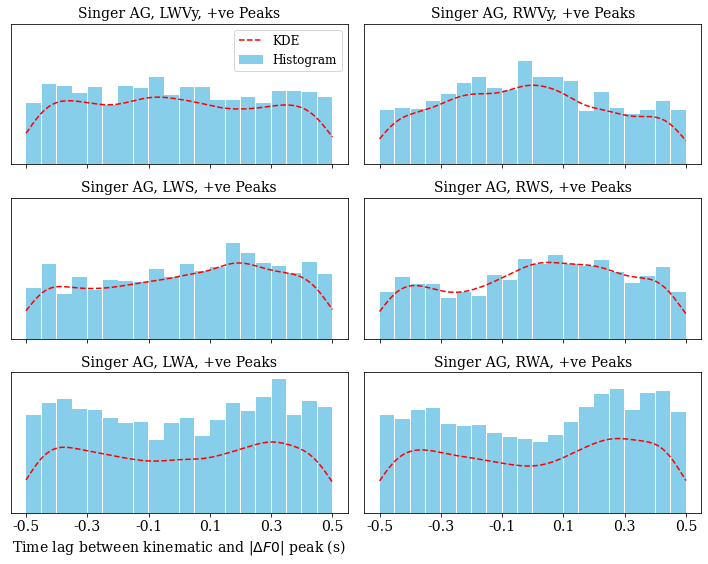

In [57]:
fig, [(ax1,ax2),(ax3,ax4),(ax5,ax6)] = plt.subplots(3,2,figsize = (10,8), 
                                                    sharex=True, sharey=True)

axes=  [ax1,ax2,ax3,ax4,ax5,ax6]

titles = ['LWVy','RWVy',
          'LWS','RWS',
          'LWA','RWA']
# scatter_colors = ['lightblue','lightblue','lightgreen','lightgreen','pink','pink']

target_col_list_reordered = ['LWrist_vel_y','RWrist_vel_y',
                             'LWrist_vel_3d','RWrist_vel_3d',
                             'LWrist_vel_accl','RWrist_vel_accl']

for i, target_col in enumerate(target_col_list_reordered):
    
    dF0_locs = pd.DataFrame([])
    
#     for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
    for singer in ['AG']:
        dF0_locs_this_singer = pos_loc_data_all[singer][target_col]
        dF0_locs_this_singer.drop(index = dF0_locs_this_singer.loc[dF0_locs_this_singer['Delta_F0_loc']==0].index, inplace=True)
        dF0_locs_this_singer.drop(index = dF0_locs_this_singer.loc[dF0_locs_this_singer['Delta_F0_loc']==100].index, inplace=True)
        dF0_locs = pd.concat([dF0_locs, dF0_locs_this_singer])
    
    dF0_locs = dF0_locs.replace(-3000,np.nan)
    dF0_locs.dropna(inplace=True)
    
    axes[i].hist(dF0_locs['Delta_F0_loc'], bins = np.arange(0,101,5),color = 'skyblue',rwidth=0.95)
    axes[i].set_title('Singer AG, '+titles[i]+', +ve Peaks', fontsize = 14)
    axes[i].set_xticks(np.arange(0,101,20), labels = np.arange(-0.5,0.51,0.2).round(2), fontsize = 14)
    axes[i].set_yticks([])
#     plt.grid(axis='x')

    kernel = gaussian_kde(dF0_locs['Delta_F0_loc'])
    factor = 0.01
    positions = np.arange(0,100,factor)
    axes[i].plot(positions, kernel(positions)*1e4, color = 'red',linestyle='dashed')

axes[0].legend(['KDE','Histogram'])
axes[4].set_xlabel('Time lag between kinematic and $|\Delta F0|$ peak (s)', fontsize=  14)
plt.tight_layout()
plt.savefig('./AG_temporal_pos.png', facecolor = 'white')
plt.show();

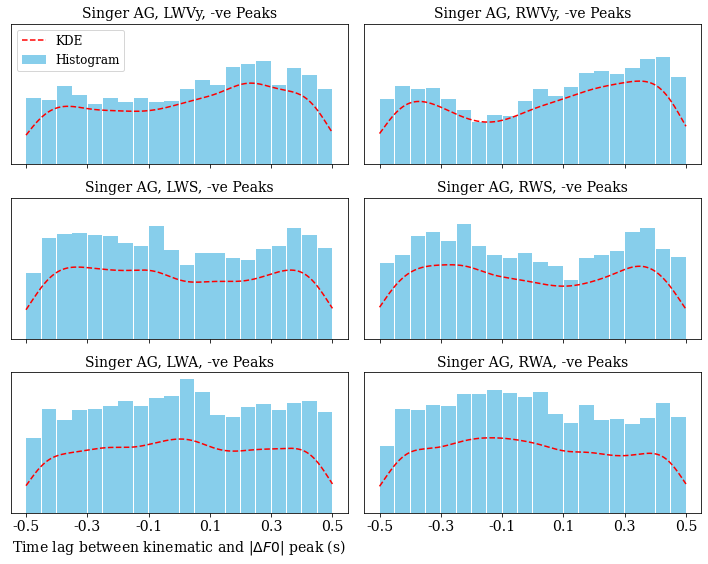

In [58]:
fig, [(ax1,ax2),(ax3,ax4),(ax5,ax6)] = plt.subplots(3,2,figsize = (10,8), 
                                                    sharex=True, sharey=True)

axes=  [ax1,ax2,ax3,ax4,ax5,ax6]

titles = ['LWVy','RWVy',
          'LWS','RWS',
          'LWA','RWA']
# scatter_colors = ['lightblue','lightblue','lightgreen','lightgreen','pink','pink']

target_col_list_reordered = ['LWrist_vel_y','RWrist_vel_y',
                             'LWrist_vel_3d','RWrist_vel_3d',
                             'LWrist_vel_accl','RWrist_vel_accl']

for i, target_col in enumerate(target_col_list_reordered):
    
    dF0_locs = pd.DataFrame([])
    
#     for singer in ['AG','AK','AP','CC','MG','MP','NM','RV','SCh','SM','SS']:
    for singer in ['AG']:
        dF0_locs_this_singer = neg_loc_data_all[singer][target_col]
        dF0_locs_this_singer.drop(index = dF0_locs_this_singer.loc[dF0_locs_this_singer['Delta_F0_loc']==0].index, inplace=True)
        dF0_locs_this_singer.drop(index = dF0_locs_this_singer.loc[dF0_locs_this_singer['Delta_F0_loc']==100].index, inplace=True)
        dF0_locs = pd.concat([dF0_locs, dF0_locs_this_singer])
    
    dF0_locs = dF0_locs.replace(-3000,np.nan)
    dF0_locs.dropna(inplace=True)
    
    axes[i].hist(dF0_locs['Delta_F0_loc'], bins = np.arange(0,101,5),color = 'skyblue',rwidth=0.95)
    axes[i].set_title('Singer AG, '+titles[i]+', -ve Peaks', fontsize = 14)
    axes[i].set_xticks(np.arange(0,101,20), labels = np.arange(-0.5,0.51,0.2).round(2), fontsize = 14)
    axes[i].set_yticks([])
#     plt.grid(axis='x')

    kernel = gaussian_kde(dF0_locs['Delta_F0_loc'])
    factor = 0.01
    positions = np.arange(0,100,factor)
    axes[i].plot(positions, kernel(positions)*1e4, color = 'red',linestyle='dashed')

axes[0].legend(['KDE','Histogram'])
axes[4].set_xlabel('Time lag between kinematic and $|\Delta F0|$ peak (s)', fontsize=  14)
plt.tight_layout()
plt.savefig('./AG_temporal_neg.png', facecolor = 'white')
plt.show();